Device: cpu
Classes: ['paper', 'rock', 'scissors']  | class_to_idx: {'paper': 0, 'rock': 1, 'scissors': 2}
RPSNet(
  (stem): ConvBNReLU(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU(inplace=True)
  )
  (stage2): Sequential(
    (0): ConvBNReLU(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage3): Sequential(
    (0): ConvBNReLU(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_

e:\anaconda\envs\Uni_env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | loss 0.8560 | train 80.99% | val 85.50% | lr 1.0e-03
Epoch 02 | loss 0.5294 | train 95.49% | val 96.07% | lr 1.0e-03
Epoch 03 | loss 0.3811 | train 94.58% | val 94.56% | lr 1.0e-03
Epoch 04 | loss 0.3271 | train 65.84% | val 69.49% | lr 1.0e-03
Epoch 05 | loss 0.2744 | train 95.56% | val 96.68% | lr 1.0e-03
Epoch 06 | loss 0.2705 | train 95.82% | val 94.56% | lr 1.0e-03
Epoch 07 | loss 0.2606 | train 98.76% | val 98.79% | lr 1.0e-03
Epoch 08 | loss 0.2508 | train 96.80% | val 96.98% | lr 1.0e-03
Đã lưu toàn bộ mô hình vào full_model.pth


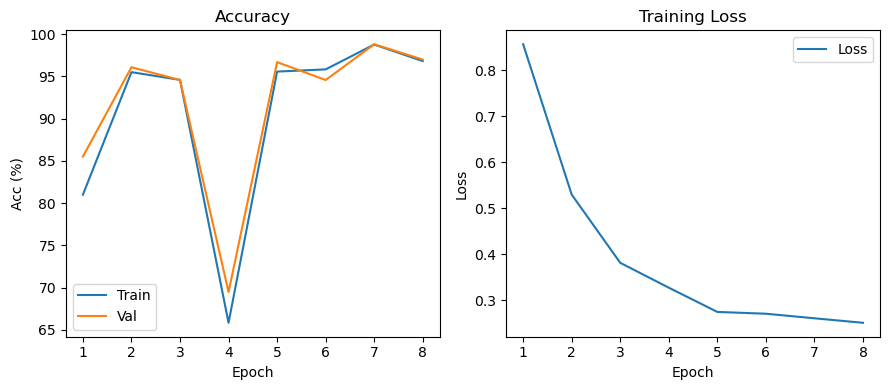

Test Accuracy: 97.55%


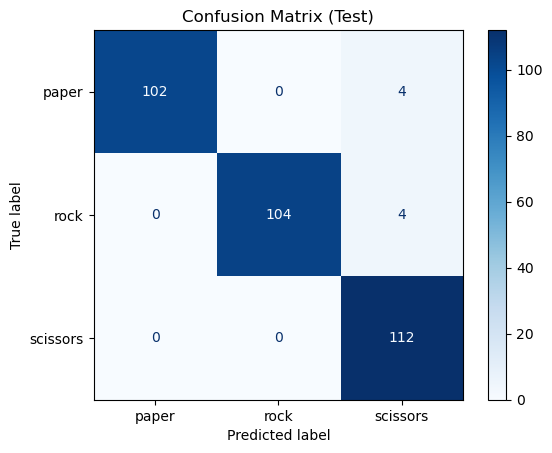

              precision    recall  f1-score   support

       paper      1.000     0.962     0.981       106
        rock      1.000     0.963     0.981       108
    scissors      0.933     1.000     0.966       112

    accuracy                          0.975       326
   macro avg      0.978     0.975     0.976       326
weighted avg      0.977     0.975     0.976       326



In [1]:
# ===================== 0) IMPORTS & SETUP =====================
import os, random, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageEnhance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ===================== 1) DATA =====================
data_dir = "./dataset"

train_transform = transforms.Compose([
    transforms.Resize((144, 144)),
    transforms.RandomResizedCrop(128, scale=(0.75, 1.0), ratio=(0.85, 1.15)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(18),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.25),
    transforms.RandomPerspective(distortion_scale=0.18, p=0.25),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

eval_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

trainset = datasets.ImageFolder(f"{data_dir}/train", transform=train_transform)
validset = datasets.ImageFolder(f"{data_dir}/validation", transform=eval_transform)
testset  = datasets.ImageFolder(f"{data_dir}/test", transform=eval_transform)

classes = trainset.classes 
print("Classes:", classes, " | class_to_idx:", trainset.class_to_idx)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
valloader   = DataLoader(validset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
testloader  = DataLoader(testset,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# ===================== 2) MODEL =====================
class ConvBNReLU(nn.Module):
    def __init__(self, in_c, out_c, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, k, s, p, bias=False)
        self.bn   = nn.BatchNorm2d(out_c)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x): 
        return self.act(self.bn(self.conv(x)))

class RPSNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.stem = ConvBNReLU(3, 32)
        self.stage2 = nn.Sequential(ConvBNReLU(32, 64), nn.MaxPool2d(2))
        self.stage3 = nn.Sequential(ConvBNReLU(64,128), nn.MaxPool2d(2))
        self.stage4 = nn.Sequential(ConvBNReLU(128,128), nn.MaxPool2d(2))
        self.head   = ConvBNReLU(128,128)
        self.gap    = nn.AdaptiveAvgPool2d(1)
        self.drop   = nn.Dropout(0.35)
        self.fc     = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.stem(x)
        x = self.stage2(x); x = self.stage3(x); x = self.stage4(x); x = self.head(x)
        x = self.gap(x).flatten(1)
        x = self.drop(x)
        return self.fc(x)

net = RPSNet(num_classes=3).to(device)
print(net)

# ===================== 3) TRAINING =====================
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

def accuracy(loader, model):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            pred = model(x).argmax(1)
            correct += (pred==y).sum().item()
            total   += y.size(0)
    return 100.0*correct/total

def train_model(model, trainloader, valloader, epochs=8, early_stop=4):
    best_val = -1; best_state=None; bad=0
    tr_hist, va_hist, loss_hist = [], [], []
    for ep in range(1,epochs+1):
        model.train(); running=0.0
        for x,y in trainloader:
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            running += loss.item()
        tr = accuracy(trainloader, model)
        va = accuracy(valloader, model)
        tr_hist.append(tr); va_hist.append(va); loss_hist.append(running/len(trainloader))
        scheduler.step(va)
        print(f"Epoch {ep:02d} | loss {loss_hist[-1]:.4f} | train {tr:.2f}% | val {va:.2f}% | lr {optimizer.param_groups[0]['lr']:.1e}")
        if va>best_val:
            best_val=va; best_state={k:v.cpu() for k,v in model.state_dict().items()}; bad=0
        else:
            bad+=1
            if bad>=early_stop:
                print("Early stopping."); break
    if best_state: model.load_state_dict({k:v.to(device) for k,v in best_state.items()})
    return tr_hist, va_hist, loss_hist

tr_hist, va_hist, loss_hist = train_model(net, trainloader, valloader, epochs=8, early_stop=4)
# Lưu toàn bộ mô hình (cả kiến trúc + weights)
torch.save(net, "full_model.pth")
print("Đã lưu toàn bộ mô hình vào full_model.pth")

# ===================== 4) PLOTS =====================
xs = range(1,len(tr_hist)+1)
plt.figure(figsize=(9,4))
plt.subplot(1,2,1); plt.plot(xs,tr_hist,label="Train"); plt.plot(xs,va_hist,label="Val"); plt.xlabel("Epoch"); plt.ylabel("Acc (%)"); plt.title("Accuracy"); plt.legend()
plt.subplot(1,2,2); plt.plot(xs,loss_hist,label="Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss"); plt.legend()
plt.tight_layout(); plt.show()

# ===================== 5) TEST & REPORT =====================
def evaluate(loader, model, classes):
    model.eval(); all_p, all_l = [], []
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device); out = model(x).argmax(1).cpu().numpy()
            all_p += list(out); all_l += list(y.numpy())
    cm = confusion_matrix(all_l, all_p)
    ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (Test)"); plt.show()
    print(classification_report(all_l, all_p, target_names=classes, digits=3))

test_acc = accuracy(testloader, net)
print(f"Test Accuracy: {test_acc:.2f}%")
evaluate(testloader, net, classes)

# ===================== 6) INFERENCE =====================
def auto_preprocess_pil(image: Image.Image):
    image = ImageOps.exif_transpose(image).convert("RGB")
    try:
        import cv2, numpy as _np
        arr = _np.array(image)
        yuv = cv2.cvtColor(arr, cv2.COLOR_RGB2YUV)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        yuv[:,:,0] = clahe.apply(yuv[:,:,0])
        arr = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
        image = Image.fromarray(arr)
    except Exception:
        image = ImageOps.autocontrast(image)
        image = ImageEnhance.Brightness(image).enhance(0.92)
        image = ImageEnhance.Contrast(image).enhance(1.25)
    return image

def predict_image(path, model, classes, show=True):
    model.eval()
    img0 = Image.open(path)
    img0 = auto_preprocess_pil(img0)

    # TTA: gốc + lật ngang
    t1 = eval_transform(img0).unsqueeze(0).to(device)
    t2 = eval_transform(ImageOps.mirror(img0)).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(t1) + model(t2)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()
        idx = int(np.argmax(probs)); name = classes[idx]

    if show:
        plt.imshow(img0); plt.title(f"Pred: {name}  |  " + "  ".join([f"{c}:{probs[i]*100:.1f}%" for i,c in enumerate(classes)])); plt.axis("off"); plt.show()
    print("Prediction:", name, {c: f"{probs[i]*100:.1f}%" for i,c in enumerate(classes)})
    return name


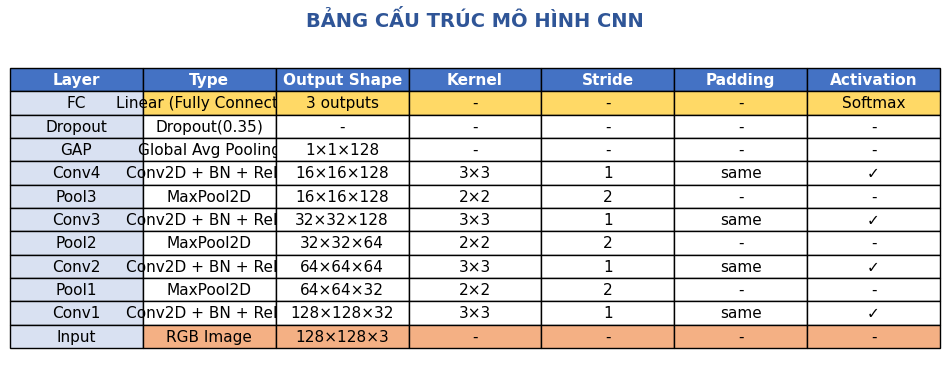

In [6]:
# ===================== 7) BẢNG KIẾN TRÚC MÔ HÌNH CNN (KIỂU ALEXNET) =====================
import pandas as pd
import matplotlib.pyplot as plt

model_table = [
    ["Input", "RGB Image", "128×128×3", "-", "-", "-", "-"],
    ["Conv1", "Conv2D + BN + ReLU", "128×128×32", "3×3", "1", "same", "✓"],
    ["Pool1", "MaxPool2D", "64×64×32", "2×2", "2", "-", "-"],
    ["Conv2", "Conv2D + BN + ReLU", "64×64×64", "3×3", "1", "same", "✓"],
    ["Pool2", "MaxPool2D", "32×32×64", "2×2", "2", "-", "-"],
    ["Conv3", "Conv2D + BN + ReLU", "32×32×128", "3×3", "1", "same", "✓"],
    ["Pool3", "MaxPool2D", "16×16×128", "2×2", "2", "-", "-"],
    ["Conv4", "Conv2D + BN + ReLU", "16×16×128", "3×3", "1", "same", "✓"],
    ["GAP", "Global Avg Pooling", "1×1×128", "-", "-", "-", "-"],
    ["Dropout", "Dropout(0.35)", "-", "-", "-", "-", "-"],
    ["FC", "Linear (Fully Connected)", "3 outputs", "-", "-", "-", "Softmax"]
]

df = pd.DataFrame(model_table[::-1], 
                  columns=["Layer", "Type", "Output Shape", "Kernel", "Stride", "Padding", "Activation"])

fig, ax = plt.subplots(figsize=(10, 4))
ax.axis("off")

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    loc="center",
    cellLoc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.4)

for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_facecolor("#4472C4")
        cell.set_text_props(weight='bold', color='white')
    elif col == 0:
        cell.set_facecolor("#D9E1F2")
    elif df.iloc[row-1, 0] == "Input":
        cell.set_facecolor("#F4B084")  # Input cam
    elif df.iloc[row-1, 0] == "FC":
        cell.set_facecolor("#FFD966")  # Output vàng

plt.title("BẢNG CẤU TRÚC MÔ HÌNH CNN", 
          fontsize=14, weight='bold', color='#2F5597', pad=20)
plt.show()


TEST

KIỂM TRA MÔ HÌNH TRÊN TẬP TEST

 ẢNH TEST (PAPER): XJlnAmd0Rb4GNRxm.png


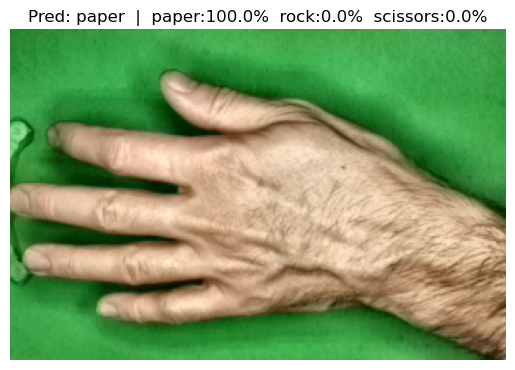

Prediction: paper {'paper': '100.0%', 'rock': '0.0%', 'scissors': '0.0%'}

 ẢNH TEST (ROCK): g04l14MAwqQthuWW.png


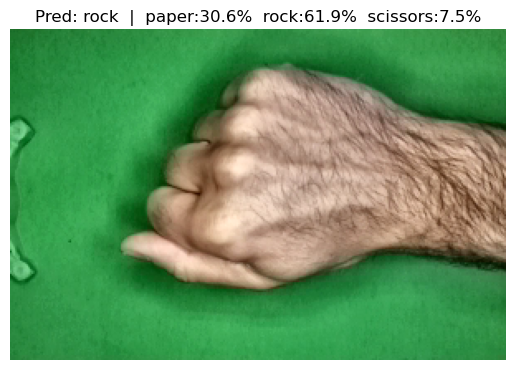

Prediction: rock {'paper': '30.6%', 'rock': '61.9%', 'scissors': '7.5%'}

 ẢNH TEST (SCISSORS): ErsQcWAahNPYPZs5.png


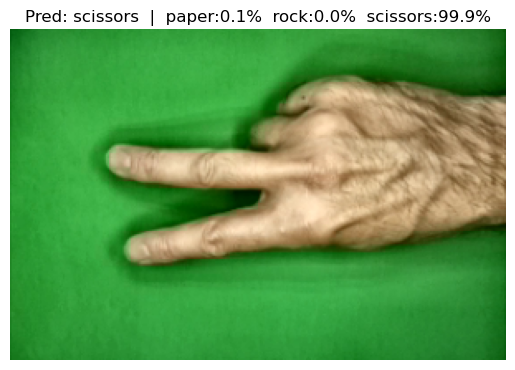

Prediction: scissors {'paper': '0.1%', 'rock': '0.0%', 'scissors': '99.9%'}

 KIỂM TRA MÔ HÌNH TRÊN ẢNH THẬT

 ẢNH THẬT: rock1.jpg


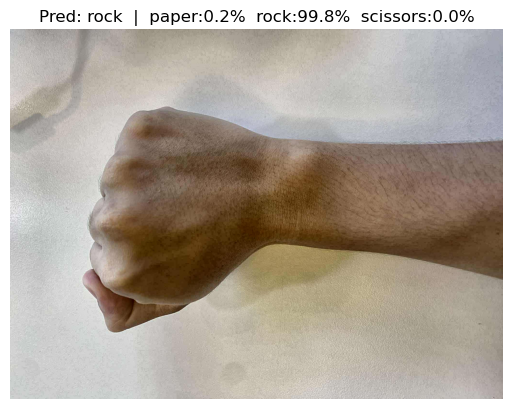

Prediction: rock {'paper': '0.2%', 'rock': '99.8%', 'scissors': '0.0%'}

 ẢNH THẬT: paper1.jpg


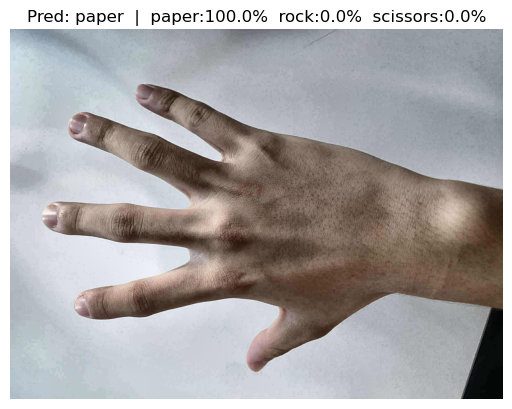

Prediction: paper {'paper': '100.0%', 'rock': '0.0%', 'scissors': '0.0%'}

 ẢNH THẬT: scissors1.jpg


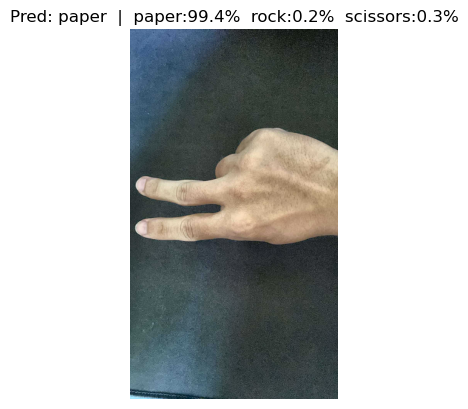

Prediction: paper {'paper': '99.4%', 'rock': '0.2%', 'scissors': '0.3%'}

 Hoàn tất kiểm tra mô hình!


In [7]:
# ===================== 8) KIỂM TRA ẢNH TRONG TẬP TEST + ẢNH THẬT =====================
import os, random
from PIL import Image

def test_model(model, data_dir, classes):
    print("="*80)
    print("KIỂM TRA MÔ HÌNH TRÊN TẬP TEST")
    print("="*80)

    # --- Ảnh ngẫu nhiên từ tập test ---
    sample_paths = []
    for cls in classes:
        folder = os.path.join(data_dir, "test", cls)
        imgs = random.sample(os.listdir(folder), 1)  # chọn 1 ảnh mỗi lớp
        for img in imgs:
            sample_paths.append(os.path.join(folder, img))

    for path in sample_paths:
        print(f"\n ẢNH TEST ({os.path.basename(os.path.dirname(path)).upper()}): {os.path.basename(path)}")
        predict_image(path, model, classes)

    print("\n" + "="*80)
    print(" KIỂM TRA MÔ HÌNH TRÊN ẢNH THẬT")
    print("="*80)

    # --- Ảnh thật bên ngoài ---
    # --- Ảnh thật bên ngoài ---
    custom_paths = [
        "image_test/rock1.jpg",
        "image_test/paper1.jpg",
        "image_test/scissors1.jpg",
    ]

    for path in custom_paths:
        if os.path.exists(path):
            print(f"\n ẢNH THẬT: {os.path.basename(path)}")
            predict_image(path, model, classes)
        else:
            print(f" Không tìm thấy file: {path}")

    print("\n Hoàn tất kiểm tra mô hình!")

# GỌI HÀM CHẠY
test_model(net, data_dir, classes)
